In [1]:
import librosa
import librosa.display
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import sys 

sys.path.append('../')

In [2]:
from src.worker.draw import draw_filtered
from src.worker.shazam_fingerprint import get_hashes_from_peaks

recording, sr = librosa.load(
    "/Users/duongtat/Work/_skola/VMM/tmp/7d3119ed1bb6bc9e65b3ed000.wav")
music, sr = librosa.load(
    "/Users/duongtat/Work/_skola/VMM/dataset/REEBOKS OR THE NIKES [fbHxkNa7lhQ].wav")


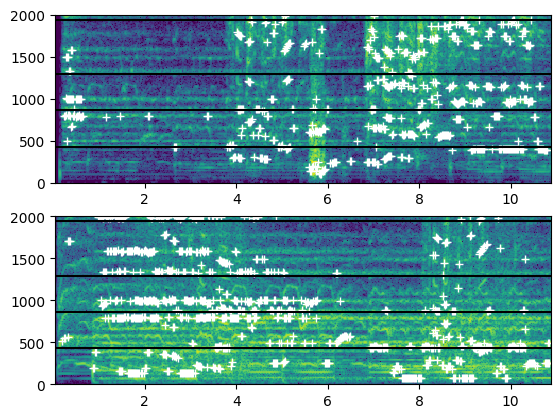

In [5]:
LIMITS = np.array([40, 80, 120, 180, 300, np.inf])
AVG_WINDOW = 150


def get_peak_frequencies(y, sr=22_050, n_fft=2_048, hop_length=2_048//4):
    """
    Extract peak frequencies for each FFT frame
    """
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

    all_frames = np.arange(S.shape[1])
    all_bins = np.arange(S.shape[0])

    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    times = librosa.frames_to_time(
        all_frames,
        sr=sr,
        hop_length=hop_length,
        n_fft=n_fft
    )

    bands = np.array([np.argmax(LIMITS >= freq) for freq in all_bins])

    S_out = np.zeros_like(S, dtype=np.bool8)

    for band in np.unique(bands):
        start_row = np.argmax(bands == band)
        end_row = len(bands) - np.argmax(bands[::-1] == band)

        slice = S[start_row:end_row]

        # Computing threshold by picking loudest freq in freq slice
        # and averaging their amplitudes (multiplied by a constant)
        amplitude_threshold = np.mean(np.max(slice, axis=0))

        # TODO: consider using moving window average instead
        # TODO: compute the mean only for single frame instead of song for comparison
        amplitude_threshold_range = np.convolve(
            np.max(slice, axis=0),
            np.ones(AVG_WINDOW) / AVG_WINDOW,
            mode="same"
        )

        # Max frequency bin index of a slice for each FFT frame
        # Not filtered by mean yet
        max_freq_bin = start_row + np.argmax(slice, axis=0)

        # Pick only frequencies, if their amplitude is higher than
        # the mean amplitude of the entire band captured from the whole song
        mask = S[max_freq_bin, all_frames] >= amplitude_threshold
        S_out[max_freq_bin[mask], all_frames[mask]] = True

    result = np.apply_along_axis(
        lambda key: np.array(
            [frequencies[key[0]], times[key[1]]]
        ),
        1,
        np.argwhere(S_out > 0)
    )

    result = result[result[:, 0].argsort()]
    result = result[result[:, 1].argsort(kind="mergesort")]

    return result


fix, axs = plt.subplots(2, 1)

draw_filtered(recording, get_peak_frequencies, limits=LIMITS, fig=axs[0])
draw_filtered(music[:recording.shape[-1]], get_peak_frequencies, limits=LIMITS, fig=axs[1])
